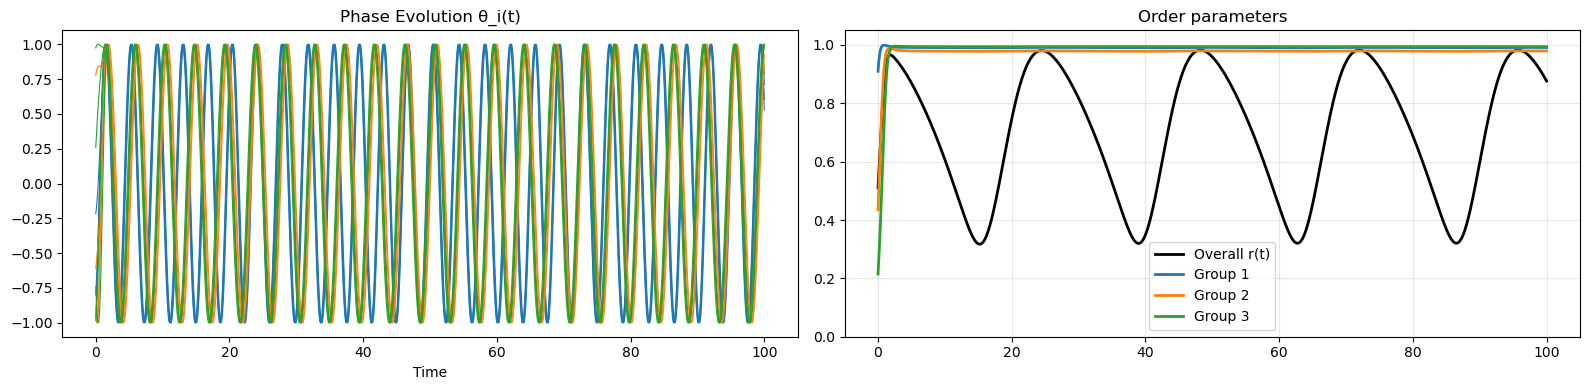

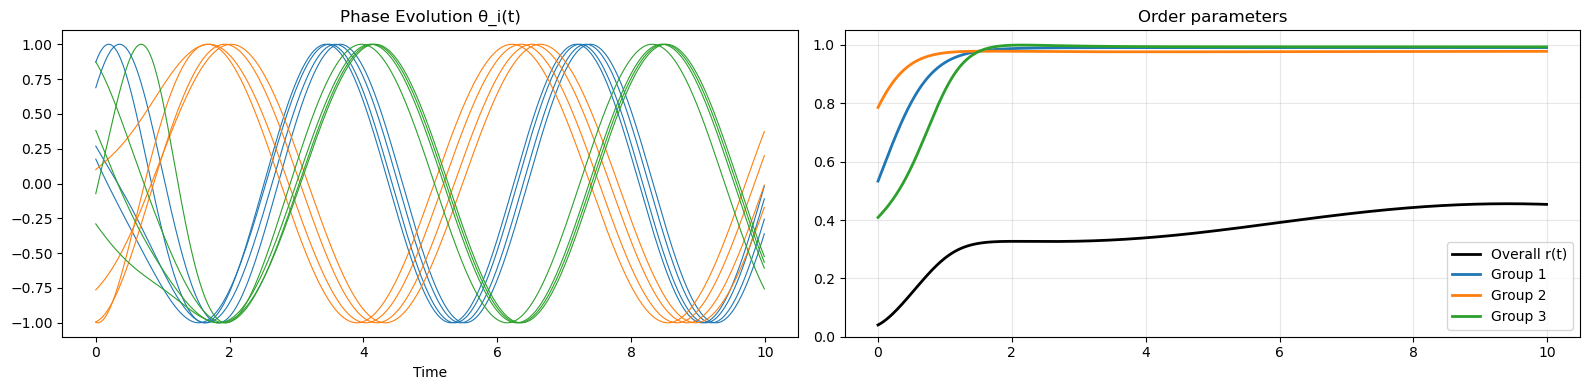

In [1]:
from deepkoop_func import Lusch
from deepkoop_func import koopman_loss,prediction_loss
from deepkoop_func import prepare_dataloader, create_sequences
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from data_func import plot_clustered_kuramoto


N=12
n_clusters=3  # 团数
K_intra=5
K_inter=0.1
noise=0
dt=0.01
x_train, theta_hist, t_train, _ = plot_clustered_kuramoto(
    N=N,          # 振子数
    n_clusters=n_clusters,  # 团数
    K_intra=K_intra,   # 团内耦合
    K_inter=K_inter,   # 团间耦合
    noise=noise,
    T=100,
    random_seed1=0, random_seed2=0,
    dt=dt
)

x_test, theta_hist, t_test, _ = plot_clustered_kuramoto(
    N=N,          # 振子数
    n_clusters=n_clusters,  # 团数
    K_intra=K_intra,   # 团内耦合
    K_inter=K_inter,   # 团间耦合
    noise=noise,
    T=10,
    random_seed1=0, random_seed2=5,
    dt=dt
)



In [1]:
import xarray as xr
from deepkoop_func import Lusch
from deepkoop_func import koopman_loss, prediction_loss, get_device
from deepkoop_func import prepare_dataloader, create_sequences
from tools import get_positive_contributions, compute_entropy
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from data_func import plot_clustered_kuramoto
import os
import random

def seed_everything(seed=42):
    """
    固定所有随机种子以确保结果可复现
    """
    # 1. Python 内置随机模块
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) # 禁止hash随机化

    # 2. Numpy
    np.random.seed(seed)

    # 3. PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    # 4. 确保算法的确定性 (CUDNN)
    # 这两行会牺牲一点点性能，但能确保卷积操作的可复现性
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 1. 路径设置 (保持你之前的路径)
file_path = r'../data_generators/dataset_yrd.nc'

# 2. 读取数据
ds = xr.open_dataset(file_path)

# --- A. 基础信息输出 ---
print("=== 维度信息 ===")
# 将 .dims 改为 .sizes
print(f"时间维度 (time): {ds.sizes['time']}")
print(f"站点维度 (station): {ds.sizes['station']}")

# 获取所有变量名 (PM2.5, O3, t2m, etc.)
var_names = list(ds.data_vars)
print(f"\n包含的变量: {var_names}")


# 如果你想把所有变量堆叠成一个大数组用于训练模型
all_data_list = []
for var in var_names:
    all_data_list.append(ds[var].values)

# stack 堆叠: axis=-1 表示在最后一个维度增加变量维
# 结果形状: (70128, 127, 10)
full_time_series_array = np.stack(all_data_list, axis=-1)

print(f"\n=== 最终合并的时间序列数组 ===")
print(f"Shape: {full_time_series_array.shape}")
print("含义: (时间步, 站点数, 特征变量数)")
print(f"其中特征顺序对应: {var_names}")

ds.close()

=== 维度信息 ===
时间维度 (time): 70128
站点维度 (station): 127

包含的变量: ['PM2.5', 'O3', 't2m', 'd2m', 'sp', 'tp', 'blh', 'msdwswrf', 'u100', 'v100']

=== 最终合并的时间序列数组 ===
Shape: (70128, 127, 10)
含义: (时间步, 站点数, 特征变量数)
其中特征顺序对应: ['PM2.5', 'O3', 't2m', 'd2m', 'sp', 'tp', 'blh', 'msdwswrf', 'u100', 'v100']


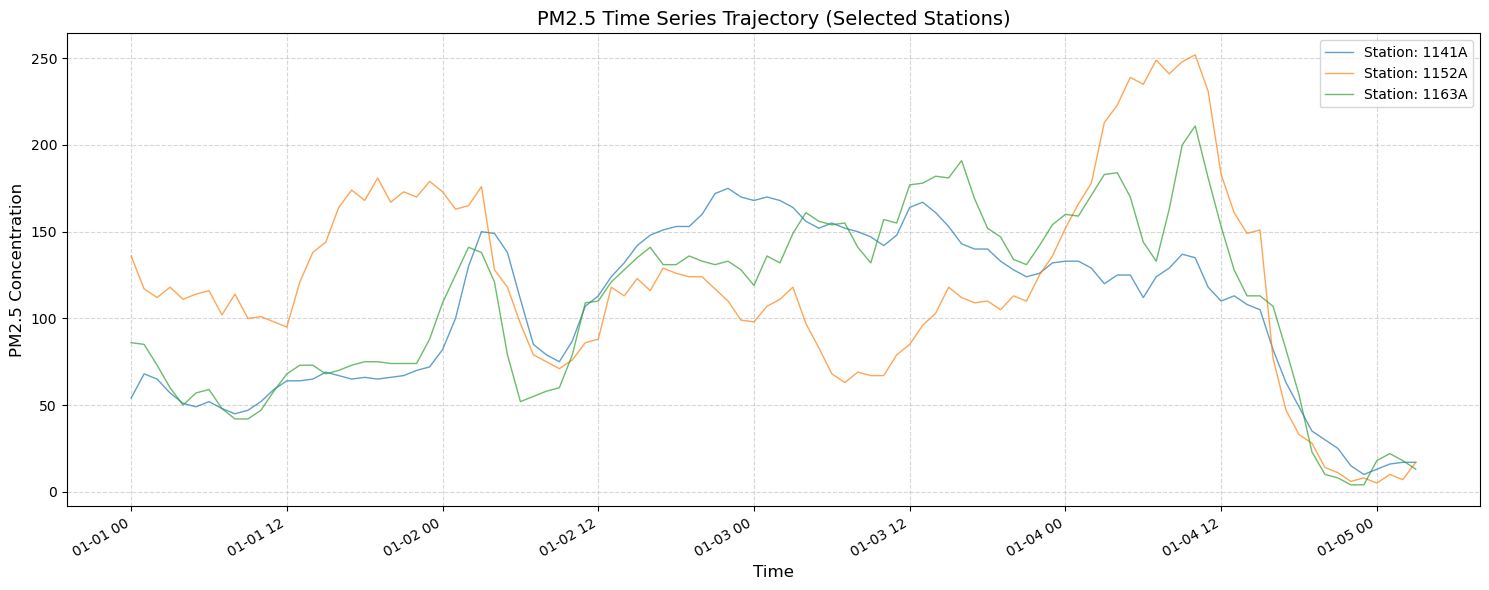

In [2]:
import matplotlib.pyplot as plt

num_stations_to_plot = 3
pm25 = ds['PM2.5']
times = ds['time'].values
stations = ds['station'].values
# 方式 A: 随机选择站点
# selected_indices = np.random.choice(len(stations), num_stations_to_plot, replace=False)

# 方式 B: 手动指定前几个站点 (比较稳定，适合观察)
selected_indices = [0, 10, 20] # 比如第1个、第11个、第21个站点

# 创建画布
plt.figure(figsize=(15, 6))

# 循环绘制选定站点的曲线
for idx in selected_indices:
    station_name = stations[idx]
    # 提取该站点的 PM2.5 数据
    # .isel(station=idx) 按索引取
    station_data = pm25.isel(station=idx).values
    
    plt.plot(times[:100], station_data[:100], label=f'Station: {station_name}', alpha=0.7, linewidth=1)

# 添加图表细节
plt.title('PM2.5 Time Series Trajectory (Selected Stations)', fontsize=14)
plt.ylabel('PM2.5 Concentration', fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)

# 优化时间轴显示 (防止重叠)
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

In [3]:
x_train = pm25.values[:60000, :]
x_test = pm25.values[60000:, :]
x_train.shape

(60000, 127)

In [ ]:
koopman_dim = 256
# encoder dim
hidden_dim = 512
input_dim = 127

epochs = 50
lr = 1e-3
Sp = 72; horizon = 72; T = max(horizon,Sp)
step_test = 5
batch_size = 256
alpha1 = 2
alpha2 = 1e-8
alpha_CE = 0
device = get_device(force_cpu=False)

  0%|          | 0/188 [00:00<?, ?it/s]/Users/yangmingzhe/Desktop/code/github/koopCE/notebooks/deepkoop_func.py:88: UserWarning: The operator 'aten::linalg_svd' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1716905753263/work/aten/src/ATen/mps/MPSFallback.mm:13.)
  _, S_tensor, _ = torch.linalg.svd(K_tensor, full_matrices=False)
/opt/anaconda3/envs/py311/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: aten::linalg_svd: an autograd kernel was not registered to the Autograd key(s) but we are trying to backprop through it. This may lead to silently incorrect behavior. This behavior is deprecated and will be removed in a future version of PyTorch. If your operator is differentiable, please ensure you have registered an autograd kernel to the correct Autograd key (e.g. DispatchKey::Autograd, DispatchKey::CompositeIm


 ==========  EPOCH 0  ==========

Prediction Loss: 251.2433
TRAIN LOSS:  14478.35880750291
TEST LOSS:  2474.7816655585107
pred LOSS:  990.5244270487035
reconstruction LOSS:  238.26838262030418
lin LOSS:  17.196061032883666
inf LOSS:  229.74907505765876
ce LOSS:  62.242794036865234


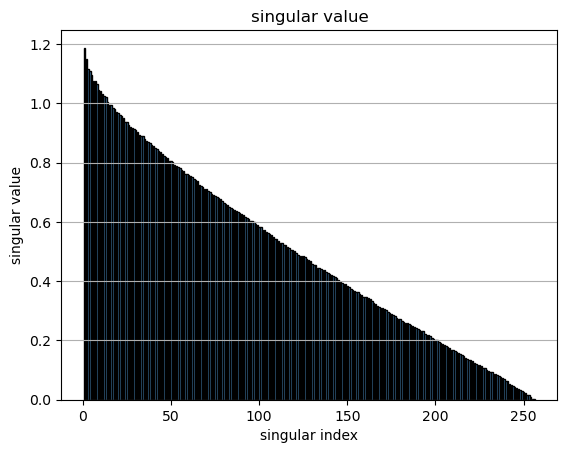

100%|██████████| 47/47 [00:02<00:00, 17.26it/s]



 ==========  EPOCH 10  ==========

Prediction Loss: 171.0126
TRAIN LOSS:  1308.2421134786402
TEST LOSS:  1303.1516580784576
pred LOSS:  593.9562566229638
reconstruction LOSS:  54.77686220534304
lin LOSS:  5.685414060633233
inf LOSS:  184.91550753978973
ce LOSS:  61.24916076660156


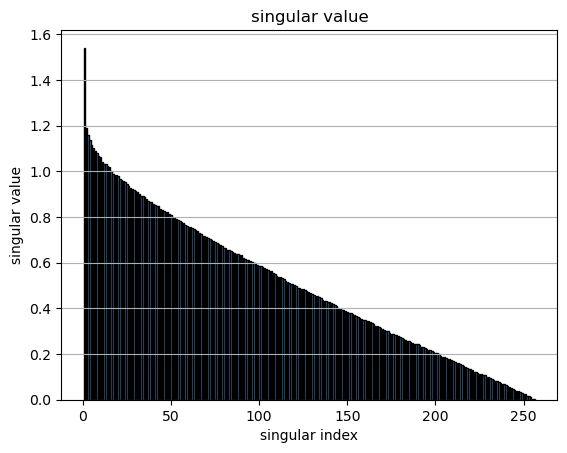

100%|██████████| 47/47 [00:02<00:00, 17.52it/s]



 ==========  EPOCH 20  ==========

Prediction Loss: 151.5374
TRAIN LOSS:  1173.8565027764503
TEST LOSS:  1219.1262414810506
pred LOSS:  558.032523297249
reconstruction LOSS:  49.853837601681974
lin LOSS:  3.353526176290309
inf LOSS:  182.7983515313331
ce LOSS:  61.184974670410156


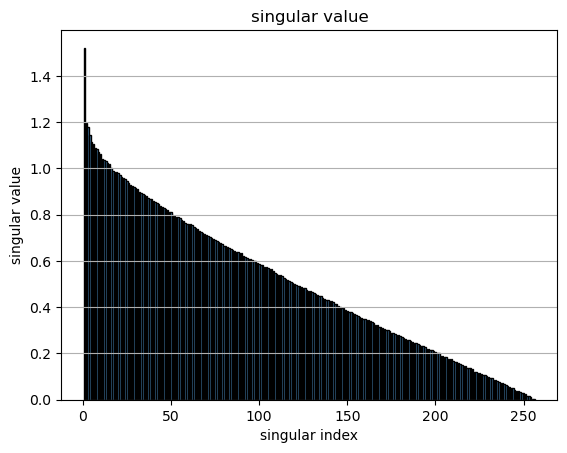

100%|██████████| 47/47 [00:02<00:00, 18.30it/s]



 ==========  EPOCH 30  ==========

Prediction Loss: 149.2594
TRAIN LOSS:  1105.1260729850608
TEST LOSS:  1141.8839565845246
pred LOSS:  527.3302125322058
reconstruction LOSS:  42.25366884596804
lin LOSS:  2.7161878575669958
inf LOSS:  182.27880567185423
ce LOSS:  60.71847915649414


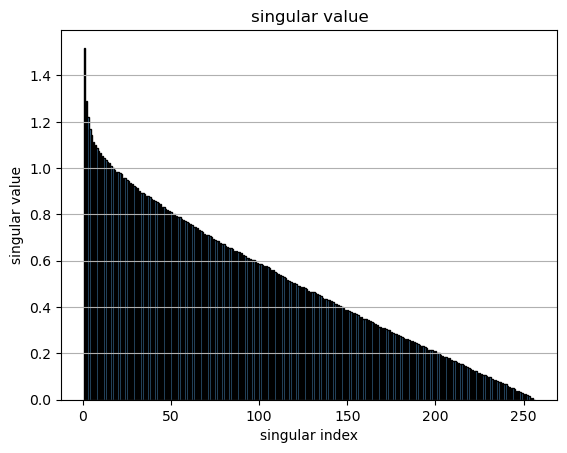

100%|██████████| 47/47 [00:02<00:00, 18.61it/s]



 ==========  EPOCH 40  ==========

Prediction Loss: 141.4118
TRAIN LOSS:  1055.6607412784658
TEST LOSS:  1111.3996608003656
pred LOSS:  514.0037211966007
reconstruction LOSS:  39.98813896990837
lin LOSS:  3.4159441704445697
inf LOSS:  178.54189349235372
ce LOSS:  60.49934768676758


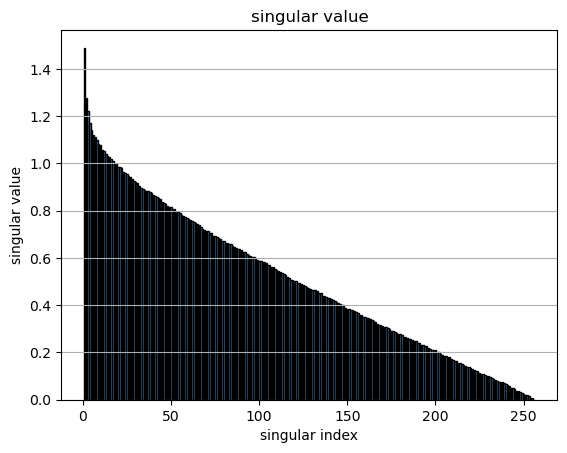

100%|██████████| 47/47 [00:02<00:00, 18.72it/s]


In [4]:
seed_everything(42)
model = Lusch(input_dim,koopman_dim,hidden_dim = hidden_dim, device=device).to(device=device)
optimizer = torch.optim.Adam(model.parameters(),lr=lr)

train_loader, val_loader = prepare_dataloader(x_train, T, batch_size=batch_size)

x_test_dims = create_sequences(x_test,step_test+1)
X_test_recon = x_test_dims[:,:-step_test,:]
X_forecast_test = x_test_dims[:,-step_test:,:]

# model.mu = train_loader.dataset.mu.to(device)
# model.std = train_loader.dataset.std.to(device)
train_losses = []; test_losses = []; pred_losses = []; reconstruction_losses = []; lin_losses = []; inf_losses = []; ce_losses = []
for epoch in range(0, epochs):
    train_epoch_loss = []
    test_epoch_loss = []
    pred_epoch_loss = []
    reconstruction_epoch_loss = []
    lin_epoch_loss = []
    inf_epoch_loss = []
    ce_epoch_loss = []

    model.train()
    for (x,) in tqdm(train_loader):
        optimizer.zero_grad()
        loss_train, _, _, _, _, _ = koopman_loss(x.to(device=device), model, Sp=Sp, T=T, alpha1=alpha1, alpha2=alpha2, alpha_CE=alpha_CE)
        loss_train.backward()
        optimizer.step()
        train_epoch_loss.append(loss_train.item())

    with torch.no_grad():
        model.eval()
        for (x,) in tqdm(val_loader):
            loss_test, pred_loss, reconstruction_loss, lin_loss, inf_loss, ce_loss = koopman_loss(x.to(device=device), model, Sp=Sp, T=T, alpha1=alpha1, alpha2=alpha2, alpha_CE=alpha_CE)
            test_epoch_loss.append(loss_test.cpu().item())
            pred_epoch_loss.append(pred_loss.cpu().item())
            reconstruction_epoch_loss.append(reconstruction_loss.cpu().item())
            lin_epoch_loss.append(lin_loss.cpu().item())
            inf_epoch_loss.append(inf_loss.cpu().item())
            ce_epoch_loss.append(ce_loss.cpu().item())

        forecast_loss = prediction_loss(X_test_recon[:,[-1],:].to(device=device), X_forecast_test.to(device=device), model)

    if epoch % 10 == 0:
        trainloss = np.sum(train_epoch_loss)/len(train_epoch_loss)
        testloss = np.sum(test_epoch_loss)/len(test_epoch_loss)
        predloss = np.sum(pred_epoch_loss)/len(pred_epoch_loss)
        reconloss = np.sum(reconstruction_epoch_loss)/len(reconstruction_epoch_loss)
        linloss = np.sum(lin_epoch_loss)/len(lin_epoch_loss)
        infloss = np.sum(inf_epoch_loss)/len(inf_epoch_loss)
        celoss = np.sum(ce_epoch_loss)/len(ce_epoch_loss)
        print("\n","="*10,f" EPOCH {epoch} ","="*10)
        print("\nPrediction Loss: {:.4f}".format(forecast_loss))
        # print("Reconstruction Loss: {:.4f}".format(reconstruction_loss))
        print("TRAIN LOSS: ", trainloss)
        print("TEST LOSS: ", testloss)
        print("pred LOSS: ", predloss)
        print("reconstruction LOSS: ", reconloss)
        print("lin LOSS: ", linloss)
        print("inf LOSS: ", infloss)
        print("ce LOSS: ", celoss)
        train_losses.append(trainloss)
        test_losses.append(testloss)
        pred_losses.append(predloss)
        reconstruction_losses.append(reconloss)
        lin_losses.append(linloss)
        inf_losses.append(infloss)
        ce_losses.append(celoss)

        K = model.koopman.linear_evolution.weight.cpu().data.numpy()
        U,S,V = np.linalg.svd(K)
        plt.figure()
        plt.bar(np.arange(1, len(S)+1), S, color='steelblue', edgecolor='k')
        plt.grid(True, axis='y')         
        plt.xlabel('singular index')
        plt.ylabel('singular value')
        plt.title('singular value')
        plt.show()

In [5]:
save_path = "model_save/air127_ce0_seed42.pth"
print(f"正在保存模型参数到 {save_path} ...")

# 核心代码：只保存 state_dict (参数字典)
torch.save(model.state_dict(), save_path)
print("保存成功！")

正在保存模型参数到 model_save/air127_ce0_seed42.pth ...
保存成功！


In [ ]:
import torch

# 1. 设置模型文件路径（需与保存时的路径一致）
load_path = "model_save/air127_ce0_seed42.pth"

model = Lusch(input_dim,koopman_dim,hidden_dim = hidden_dim, device=device).to(device=device)

print(f"正在从 {load_path} 加载模型参数 ...")

try:
    # 3. 加载参数字典
    # map_location='cpu' 确保即使模型是在GPU上训练的，也能在没有GPU的机器上加载
    checkpoint = torch.load(load_path, map_location='cpu')
    
    # 4. 将参数加载到模型中
    # strict=True (默认) 会严格检查键值是否匹配，如果你的模型结构改了，这里会报错
    model.load_state_dict(checkpoint, strict=True)
    
    print("参数加载成功！")

    print("模型已切换至评估模式，可以进行预测了。")

except FileNotFoundError:
    print(f"错误：找不到文件 {load_path}，请检查路径。")
except RuntimeError as e:
    print(f"加载失败，通常是因为模型结构不匹配：\n{e}")

cpu: 51min; mps: 17min

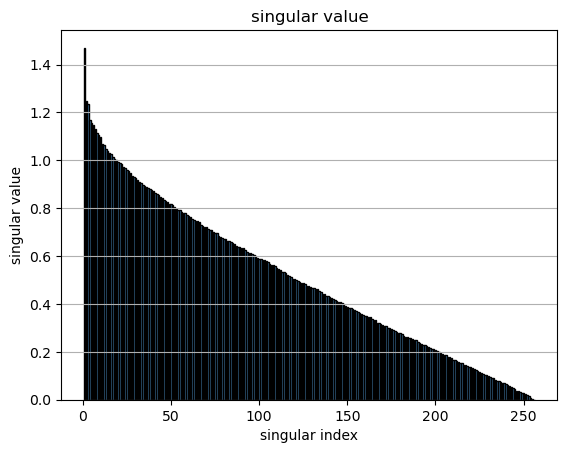

In [6]:
model.eval()
K = model.koopman.linear_evolution.weight.cpu().data.numpy()
U,S,V = np.linalg.svd(K)
plt.figure()
plt.bar(np.arange(1, len(S)+1), S, color='steelblue', edgecolor='k')
plt.grid(True, axis='y')         
plt.xlabel('singular index')
plt.ylabel('singular value')
plt.title('singular value')
plt.show()

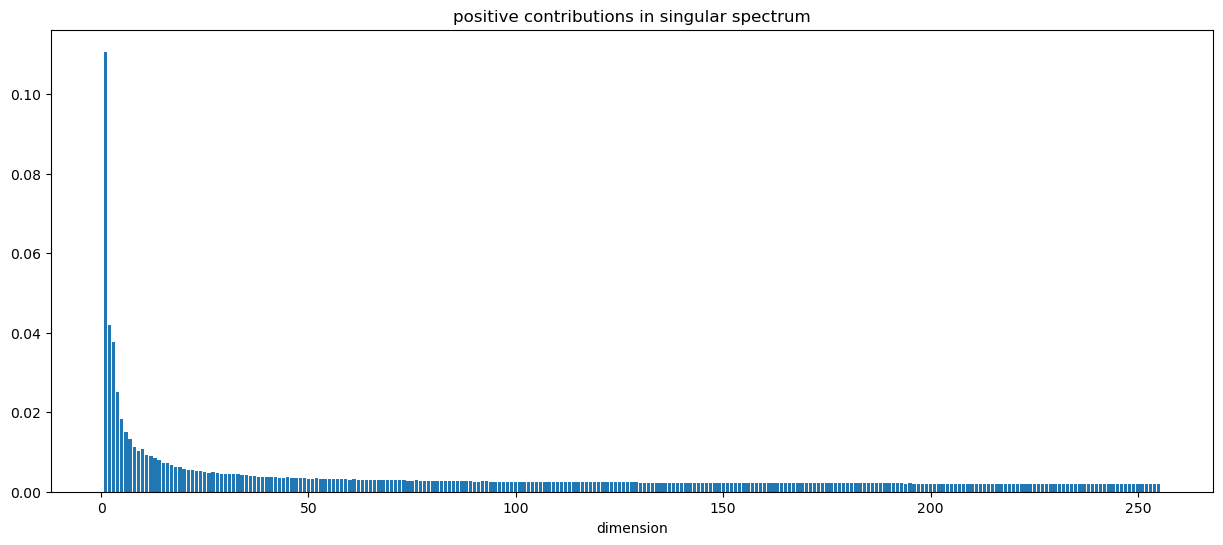

In [7]:
# 多尺度因果力分布
diff = get_positive_contributions(S)
plt.figure(figsize=(15, 6))
plt.bar(range(1,len(diff)+1), diff) 
plt.xlabel('dimension')
plt.title('positive contributions in singular spectrum')
plt.show()

In [8]:
# 计算EC
print(compute_entropy(diff))

7.18777


In [9]:
from pysr import PySRRegressor
from deepkoop_func import eq_coarse_grain

rank = 2
coarse_grain_coff = U[:,:rank]
X_np, macro_data = eq_coarse_grain(model, train_loader, coarse_grain_coff, num_samples=1000)
print(f"Sampled shapes: micro={X_np.shape}, macro={macro_data.shape}")

/opt/anaconda3/envs/py311/lib/python3.11/site-packages/juliacall/__init__.py:61: UserWarning: torch was imported before juliacall. This may cause a segfault. To avoid this, import juliacall before importing torch. For updates, see https://github.com/pytorch/pytorch/issues/78829.
  warnings.warn(


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython
Sampled shapes: micro=(1000, 127), macro=(1000, 2)


/var/folders/mw/53dhwskj4zq47dtls4lhht4m0000gn/T/ipykernel_11722/3662134056.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


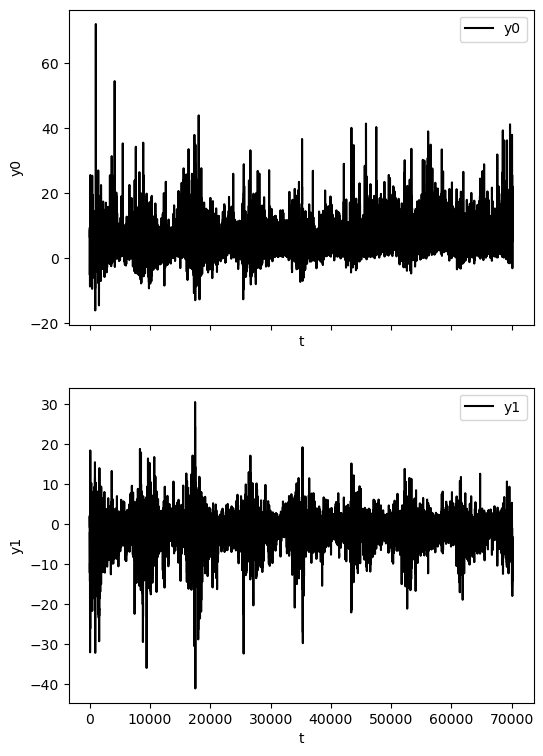

In [12]:
micro_data = torch.tensor(pm25.values, device=device)
g = model.encoder(micro_data)
macro_serie = g.cpu().detach().numpy() @ coarse_grain_coff

macro_dim = macro_serie.shape[1]

fig, axs = plt.subplots(macro_dim, 1, sharex=True, figsize=(int(3*macro_dim), 9))
for i in range(macro_dim):
    axs[i].plot(macro_serie[:, i], "k", label=f"y{i}")
    axs[i].legend()
    axs[i].set(xlabel="t", ylabel=f"y{i}")
fig.show()

In [10]:
default_pysr_params = dict(
    populations=100,
    model_selection="accuracy", #best, accuracy
    niterations=40, # 迭代次数越多越精确，但越慢
    # 选择适合动力系统的算子
    binary_operators=["+", "-", "*", "/"],
    unary_operators=[
        "cos", "sin", "square", "sqrt"
    ],
    maxsize=25, # 限制公式复杂度
    temp_equation_file=False, 
    delete_tempfiles=True,
    verbosity=0,
    denoise=False,
    procs=4, # 并行核心数
)

encoder_eqs = []
latent_dim = macro_data.shape[1]

for i in range(latent_dim):
    print(f"--- Fitting Latent Dimension g_{i} ---")
    model_sr = PySRRegressor(**default_pysr_params)
    model_sr.fit(X_np, macro_data[:, i])
    
    eq = model_sr.sympy()
    encoder_eqs.append(eq)
    print(f"Y_{i} = {eq}")

# decoder_eqs = []
# input_dim = X_np.shape[1]

# for i in range(input_dim):
#     print(f"--- Fitting Observable Dimension x_{i} ---")
#     model_sr = PySRRegressor(**default_pysr_params)
#     model_sr.fit(macro_data, X_np[:, i])
    
#     eq = model_sr.sympy()
#     decoder_eqs.append(eq)
#     print(f"x_{i} = {eq}")


--- Fitting Latent Dimension g_0 ---


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/envs/py311/lib/python3.11/site-packages/pysr/sr.py:96: UserWarning: You are using the `^` operator, but have not set up `constraints` for it. This may lead to overly complex expressions. One typical constraint is to use `constraints={..., '^': (-1, 1)}`, which will allow arbitrary-complexity base (-1) but only powers such as a constant or variable (1). For more tips, please see https://ai.damtp.cam.ac.uk/pysr/tuning/
  warnings.warn(


Y_0 = (2.0276968 + (x113/((x107/x99 - 0.4798503)**x85 + 1.5988652) + x13 + x67 - x88 + x99)*(-0.023124624))*(-2.2920766)
--- Fitting Latent Dimension g_1 ---


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/envs/py311/lib/python3.11/site-packages/pysr/sr.py:96: UserWarning: You are using the `^` operator, but have not set up `constraints` for it. This may lead to overly complex expressions. One typical constraint is to use `constraints={..., '^': (-1, 1)}`, which will allow arbitrary-complexity base (-1) but only powers such as a constant or variable (1). For more tips, please see https://ai.damtp.cam.ac.uk/pysr/tuning/
  warnings.warn(


Y_1 = -0.020992607*x16/sqrt(x60) - 0.0351678333878395*x28 - 0.020992607*x3 - 0.0351678333878395*x42/sqrt(x57) + 0.0351678333878395*x52 + 0.0351678333878395*x79 - 0.0351678333878395*x86 + 0.3158994


In [12]:
print("\n[Encoder Functions]:")
variable_names_x = [f"x{i}" for i in range(X_np.shape[1])]
for i, eq in enumerate(encoder_eqs):
    print(f"Y[{i}] = {eq}")


# print("\n[Decoder Functions]:")
# for i, eq in enumerate(decoder_eqs):
#     print(f"x[{i}] = {eq}")


[Encoder Functions]:
Y[0] = -x0 - (x106 + x35 + x39 + x93 + x95) - (x104 + x119 + x70 + x77 + x98 - 1*(-9.109035)) - 8.241279
Y[1] = x119/(1.3845075*(x26 - 0.32864743)) + (x93 - x96/(-0.9030943) + (x43 + x80)**0.77309614 - 1*0.39167592)*(-0.39453307)


In [11]:
print("\n[Encoder Functions]:")
variable_names_x = [f"x{i}" for i in range(X_np.shape[1])]
for i, eq in enumerate(encoder_eqs):
    print(f"Y[{i}] = {eq}")


[Encoder Functions]:
Y[0] = (2.0276968 + (x113/((x107/x99 - 0.4798503)**x85 + 1.5988652) + x13 + x67 - x88 + x99)*(-0.023124624))*(-2.2920766)
Y[1] = -0.020992607*x16/sqrt(x60) - 0.0351678333878395*x28 - 0.020992607*x3 - 0.0351678333878395*x42/sqrt(x57) + 0.0351678333878395*x52 + 0.0351678333878395*x79 - 0.0351678333878395*x86 + 0.3158994
